# Problem description
The state variables are        $
x = \begin{bmatrix}x\\ y\\ \phi \end{bmatrix}
$ $\quad$
$
u = \begin{bmatrix}v_x\\ \omega \end{bmatrix}
$

$$
\dot{x} = \begin{bmatrix}v_x\cos\phi \\ v_x\sin\phi \\ \omega \end{bmatrix}
$$

There's a desired point to be at $(x_r,y_r)$

We define:
- $e_x=(x-x_r)$
- $e_y=(y-y_r)$

we want to minimize:
$$
e_x^2+e_y^2
$$

In [2]:
import casadi as ca
import numpy as np

In [22]:
# MPC Parameters
N = 10  # Prediction horizon (number of time steps)
T = 0.1  # Sampling time

# Create optimization problem
opti = ca.Opti()

# State and control dimensions
n_states = 3  # [x, y, phi]
n_controls = 2  # [v_x, omega]

# Decision variables over the prediction horizon
X = opti.variable(n_states, N+1)  # States over horizon: [x, y, phi] for N+1 time steps
U = opti.variable(n_controls, N)  # Controls over horizon: [v_x, omega] for N time steps

# Reference point
x_r, y_r = 10, 10

# Parameters (initial state)
P = opti.parameter(n_states, 1)  # Initial state parameter

# Define dynamics function
def dynamics(x, u):
    """State dynamics: x_dot = f(x, u)"""
    x_pos, y_pos, phi = x[0], x[1], x[2]
    v_x, omega = u[0], u[1]
    
    x_dot = ca.vertcat(
        v_x * ca.cos(phi),  # x_dot
        v_x * ca.sin(phi),  # y_dot  
        omega               # phi_dot
    )
    return x_dot

# RK4 integration function
def rk4_step(x, u, dt):
    """Single RK4 integration step"""
    k1 = dynamics(x, u)
    k2 = dynamics(x + dt/2 * k1, u)
    k3 = dynamics(x + dt/2 * k2, u)
    k4 = dynamics(x + dt * k3, u)
    
    x_next = x + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
    return x_next

# Cost function weights
Q = ca.diag([10, 10])  # State cost weights [x, y, phi]
R = ca.diag([1, 1])       # Control cost weights [v_x, omega]
Q1 = ca.diag([1, 1, 1])  # Terminal state cost weights [x, y, phi]
# Initialize cost
cost = 0

# Apply dynamics constraints and build cost function
for k in range(N):
    # Current state and control
    x_k = X[:, k]
    u_k = U[:, k]
    x_next = X[:, k+1]
    
    # Dynamics constraint using RK4 integration
    x_predicted = rk4_step(x_k, u_k, T)
    opti.subject_to(x_next == x_predicted)
    
    # Stage cost (tracking error + control effort)
    x_pos_k, y_pos_k = x_k[0], x_k[1]
    e_x = x_pos_k - x_r
    e_y = y_pos_k - y_r
    error_state = ca.vertcat(e_x, e_y)  # Include phi in state cost
    
    stage_cost = error_state.T @ Q @ error_state + u_k.T @ R @ u_k
    cost += stage_cost

# Terminal cost (final state)
x_final = X[:, N]
e_x_final = x_final[0] - x_r
e_y_final = x_final[1] - y_r
error_final = ca.vertcat(e_x_final, e_y_final, x_final[2])
terminal_cost = error_final.T @ Q1 @ error_final
cost += terminal_cost

# Set objective
opti.minimize(cost)

# Initial condition constraint
opti.subject_to(X[:, 0] == P)

# Control constraints (optional)
for k in range(N):
    opti.subject_to(U[0, k] >= 0)      # Forward motion only
    opti.subject_to(U[0, k] <= 5)      # Max velocity
    opti.subject_to(U[1, k] >= -1)     # Min angular velocity
    opti.subject_to(U[1, k] <= 1)      # Max angular velocity

# State constraints (optional)
# for k in range(N+1):
#     opti.subject_to(X[0, k] >= -20)  # x bounds
#     opti.subject_to(X[0, k] <= 20)   
#     opti.subject_to(X[1, k] >= -20)  # y bounds
#     opti.subject_to(X[1, k] <= 20)

# Solver settings
opts = {
    'ipopt.print_level': 0,
    'print_time': 0,
    'ipopt.tol': 1e-6
}
opti.solver('ipopt', opts)

print("MPC Problem setup complete!")
print(f"Prediction horizon N: {N}")
print(f"Sampling time T: {T} seconds")
print(f"Integration method: RK4 (4th order Runge-Kutta)")
print(f"State variables shape: {X.shape} (3 states × {N+1} time steps)")
print(f"Control variables shape: {U.shape} (2 controls × {N} time steps)")

MPC Problem setup complete!
Prediction horizon N: 10
Sampling time T: 0.1 seconds
Integration method: RK4 (4th order Runge-Kutta)
State variables shape: (3, 11) (3 states × 11 time steps)
Control variables shape: (2, 10) (2 controls × 10 time steps)


In [24]:
# RK4 integration for simulation (matching MPC dynamics)
def simulate_rk4_step(x_current, u_applied, dt):
    """RK4 integration step for simulation"""
    def dynamics_numpy(x, u):
        v_x, omega = u[0], u[1]
        return np.array([
            v_x * np.cos(x[2]),  # x_dot
            v_x * np.sin(x[2]),  # y_dot
            omega                # phi_dot
        ])
    
    k1 = dynamics_numpy(x_current, u_applied)
    k2 = dynamics_numpy(x_current + dt/2 * k1, u_applied)
    k3 = dynamics_numpy(x_current + dt/2 * k2, u_applied)
    k4 = dynamics_numpy(x_current + dt * k3, u_applied)
    
    x_next = x_current + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
    return x_next

# MPC Receding Horizon Control Loop
print("=== MPC Receding Horizon Control Loop ===")
print(f"Target: [{x_r}, {y_r}]")

# Simulation parameters
x_current = np.array([0.0, 0.0, 0.0])  # Current state [x, y, phi]
tolerance = 0.1  # Distance tolerance to target
max_iterations = 1000  # Maximum number of MPC iterations
trajectory_x = [x_current[0]]  # Store trajectory for plotting
trajectory_y = [x_current[1]]
control_history = []  # Store control inputs

print(f"Tolerance: {tolerance}")
print(f"Max iterations: {max_iterations}")
print(f"Integration: RK4")
print()

# Main MPC loop
for iteration in range(max_iterations):
    # Calculate distance to target
    distance_to_target = np.sqrt((x_current[0] - x_r)**2 + (x_current[1] - y_r)**2)
    
    # Check if we've reached the target
    if distance_to_target < tolerance:
        print(f"\n✅ Target reached in {iteration} steps!")
        print(f"Final state: [{x_current[0]:.2f}, {x_current[1]:.2f}, {x_current[2]:.2f}]")
        print(f"Final distance to target: {distance_to_target:.2f}")
        break
    
    # Set current state as initial condition for MPC
    opti.set_value(P, x_current)
    
    # Set initial guess for optimization (warm start with previous solution if available)
    for k in range(N+1):
        # Linear interpolation from current to reference
        alpha = k / N
        opti.set_initial(X[0, k], x_current[0] + alpha * (x_r - x_current[0]))  # x
        opti.set_initial(X[1, k], x_current[1] + alpha * (y_r - x_current[1]))  # y  
        opti.set_initial(X[2, k], x_current[2])  # phi

    for k in range(N):
        opti.set_initial(U[0, k], 1)  # v_x
        opti.set_initial(U[1, k], 0)  # omega
    
    try:
        # Solve MPC optimization problem
        sol = opti.solve()
        
        # Extract optimal control sequence
        U_opt = sol.value(U)
        
        # Apply first control action (receding horizon principle)
        u_applied = U_opt[:, 0]
        control_history.append(u_applied.copy())
        
        # Print current status
        print(f"Step {iteration}: State=[{x_current[0]:.2f}, {x_current[1]:.2f}, {x_current[2]:.2f}], "
              f"Distance={distance_to_target:.2f}, Control=[{u_applied[0]:.3f}, {u_applied[1]:.3f}]")
        
        # Simulate system forward by one time step using RK4 integration
        x_current = simulate_rk4_step(x_current, u_applied, T)
        
        # Store trajectory
        trajectory_x.append(x_current[0])
        trajectory_y.append(x_current[1])
        
    except Exception as e:
        print(f"\n❌ MPC solver failed at iteration {iteration}: {e}")
        break

else:
    # Loop completed without reaching target
    distance_to_target = np.sqrt((x_current[0] - x_r)**2 + (x_current[1] - y_r)**2)
    print(f"\n❌ Failed to reach target within {max_iterations} iterations")
    print(f"Final state: [{x_current[0]:.2f}, {x_current[1]:.2f}, {x_current[2]:.2f}]")
    print(f"Final distance to target: {distance_to_target:.2f}")

=== MPC Receding Horizon Control Loop ===
Target: [10, 10]
Tolerance: 0.1
Max iterations: 1000
Integration: RK4

Step 0: State=[0.00, 0.00, 0.00], Distance=14.14, Control=[5.000, 1.000]
Step 1: State=[0.50, 0.02, 0.10], Distance=13.78, Control=[5.000, 1.000]
Step 2: State=[0.99, 0.10, 0.20], Distance=13.38, Control=[5.000, 1.000]
Step 3: State=[1.48, 0.22, 0.30], Distance=12.97, Control=[5.000, 1.000]
Step 4: State=[1.95, 0.39, 0.40], Distance=12.53, Control=[5.000, 1.000]
Step 5: State=[2.40, 0.61, 0.50], Distance=12.08, Control=[5.000, 1.000]
Step 6: State=[2.82, 0.87, 0.60], Distance=11.61, Control=[5.000, 1.000]
Step 7: State=[3.22, 1.18, 0.70], Distance=11.13, Control=[5.000, 1.000]
Step 8: State=[3.59, 1.52, 0.80], Distance=10.63, Control=[5.000, 1.000]
Step 9: State=[3.92, 1.89, 0.90], Distance=10.14, Control=[5.000, 0.252]
Step 10: State=[4.22, 2.29, 0.93], Distance=9.64, Control=[5.000, 0.026]
Step 11: State=[4.52, 2.69, 0.93], Distance=9.14, Control=[5.000, 0.003]
Step 12: St

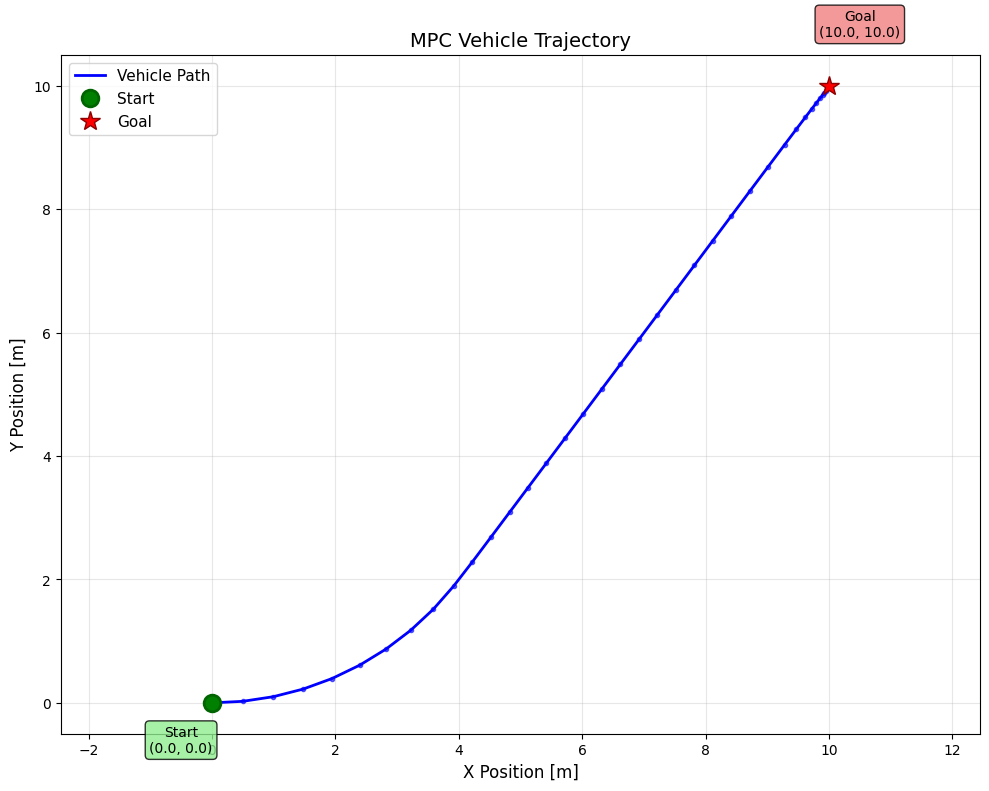

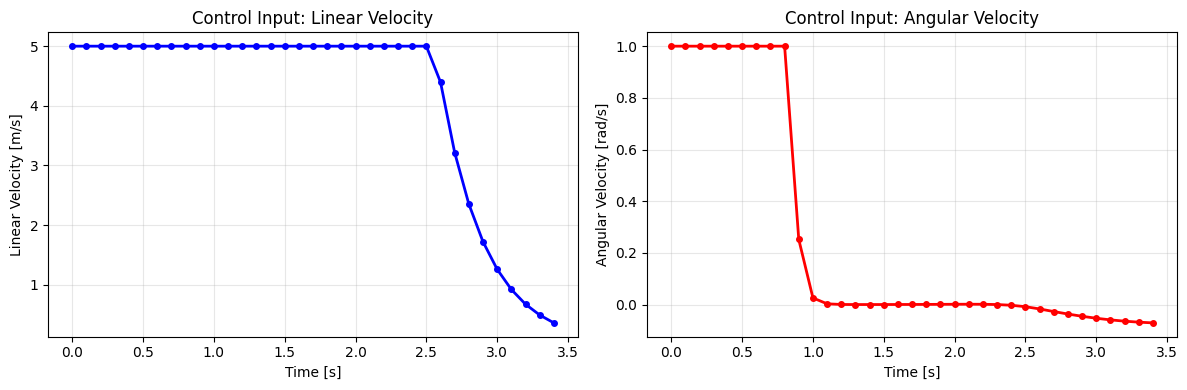


Creating animation...


SyntaxError: name 'vehicle_arrow' is used prior to global declaration (2950415995.py, line 102)

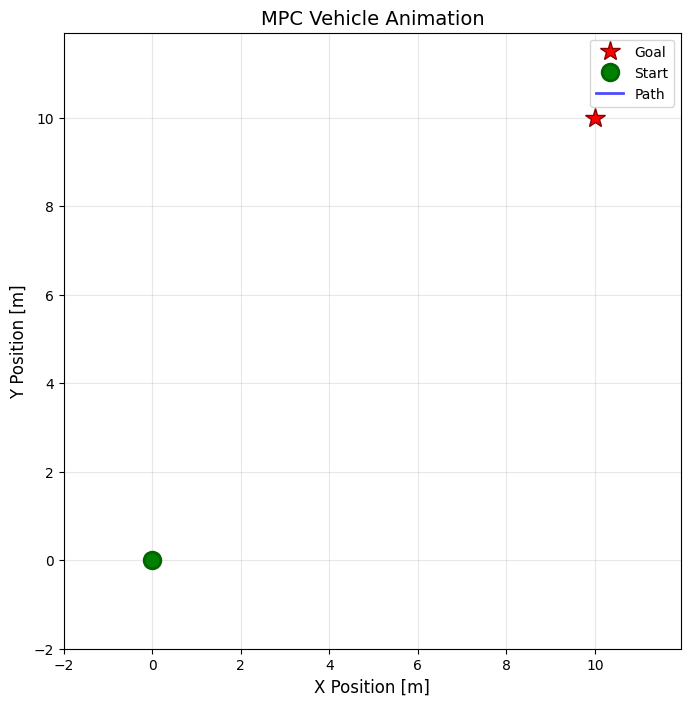

In [25]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import FancyArrow
import numpy as np

# Static visualization
plt.figure(figsize=(10, 8))

# Plot the complete trajectory
plt.plot(trajectory_x, trajectory_y, 'b-', linewidth=2, label='Vehicle Path')
plt.plot(trajectory_x, trajectory_y, 'bo', markersize=3, alpha=0.6)

# Plot start location
plt.plot(trajectory_x[0], trajectory_y[0], 'go', markersize=12, label='Start', markeredgecolor='darkgreen', markeredgewidth=2)

# Plot goal point  
plt.plot(x_r, y_r, 'r*', markersize=15, label='Goal', markeredgecolor='darkred', markeredgewidth=1)

# Add labels and formatting
plt.xlabel('X Position [m]', fontsize=12)
plt.ylabel('Y Position [m]', fontsize=12)
plt.title('MPC Vehicle Trajectory', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.axis('equal')

# Add text annotations
plt.text(trajectory_x[0]-0.5, trajectory_y[0]-0.8, f'Start\n({trajectory_x[0]:.1f}, {trajectory_y[0]:.1f})', 
         ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
plt.text(x_r+0.5, y_r+0.8, f'Goal\n({x_r:.1f}, {y_r:.1f})', 
         ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

plt.tight_layout()
plt.show()

# Plot control inputs over time
if control_history:
    control_array = np.array(control_history)
    time_steps = np.arange(len(control_history)) * T

    plt.figure(figsize=(12, 4))

    # Velocity plot
    plt.subplot(1, 2, 1)
    plt.plot(time_steps, control_array[:, 0], 'b-o', linewidth=2, markersize=4)
    plt.xlabel('Time [s]')
    plt.ylabel('Linear Velocity [m/s]')
    plt.title('Control Input: Linear Velocity')
    plt.grid(True, alpha=0.3)

    # Angular velocity plot  
    plt.subplot(1, 2, 2)
    plt.plot(time_steps, control_array[:, 1], 'r-o', linewidth=2, markersize=4)
    plt.xlabel('Time [s]')
    plt.ylabel('Angular Velocity [rad/s]')
    plt.title('Control Input: Angular Velocity')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Animated visualization
print("\nCreating animation...")

# Set up the figure and axis for animation
fig, ax = plt.subplots(figsize=(10, 8))

# Set axis limits based on trajectory
x_min, x_max = min(trajectory_x) - 2, max(trajectory_x) + 2
y_min, y_max = min(trajectory_y) - 2, max(trajectory_y) + 2
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel('X Position [m]', fontsize=12)
ax.set_ylabel('Y Position [m]', fontsize=12)
ax.set_title('MPC Vehicle Animation', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# Plot static elements
ax.plot(x_r, y_r, 'r*', markersize=15, label='Goal', markeredgecolor='darkred', markeredgewidth=1)
ax.plot(trajectory_x[0], trajectory_y[0], 'go', markersize=12, label='Start', markeredgecolor='darkgreen', markeredgewidth=2)

# Initialize animated elements
trajectory_line, = ax.plot([], [], 'b-', linewidth=2, alpha=0.7, label='Path')
vehicle_dot, = ax.plot([], [], 'bo', markersize=8, markeredgecolor='darkblue', markeredgewidth=2)
vehicle_arrow = ax.add_patch(plt.Circle((0, 0), 0, visible=False))  # Placeholder, will be replaced

ax.legend()

def animate(frame):
    """Animation function called for each frame"""
    if frame >= len(trajectory_x):
        return trajectory_line, vehicle_dot, vehicle_arrow
    
    # Update trajectory line (show path up to current point)
    trajectory_line.set_data(trajectory_x[:frame+1], trajectory_y[:frame+1])
    
    # Update vehicle position
    vehicle_dot.set_data([trajectory_x[frame]], [trajectory_y[frame]])
    
    # Remove previous arrow and add new one with vehicle orientation
    global vehicle_arrow
    vehicle_arrow.remove()
    
    if frame < len(control_history):
        # Calculate vehicle heading from control history
        if frame == 0:
            phi = 0  # Initial heading
        else:
            # Approximate heading from trajectory
            if frame > 0:
                dx = trajectory_x[frame] - trajectory_x[frame-1]
                dy = trajectory_y[frame] - trajectory_y[frame-1]
                phi = np.arctan2(dy, dx)
            else:
                phi = 0
        
        # Create arrow showing vehicle orientation
        arrow_length = 1.0
        dx = arrow_length * np.cos(phi)
        dy = arrow_length * np.sin(phi)
        
        vehicle_arrow = ax.add_patch(FancyArrow(
            trajectory_x[frame], trajectory_y[frame], dx, dy,
            head_width=0.3, head_length=0.2, 
            fc='red', ec='red', alpha=0.8
        ))
    
    return trajectory_line, vehicle_dot, vehicle_arrow

# Create animation
print(f"Animating {len(trajectory_x)} frames...")
anim = animation.FuncAnimation(
    fig, animate, frames=len(trajectory_x), 
    interval=100,  # 100ms between frames
    blit=False, repeat=True
)

plt.tight_layout()
plt.show()

# Optional: Save animation as GIF (uncomment to save)
# print("Saving animation as GIF...")
# anim.save('mpc_trajectory.gif', writer='pillow', fps=10)
# print("Animation saved as 'mpc_trajectory.gif'")

print(f"\nFinal trajectory statistics:")
print(f"Total steps: {len(trajectory_x)-1}")
print(f"Total time: {(len(trajectory_x)-1) * T:.1f} seconds")
print(f"Final distance to goal: {np.sqrt((trajectory_x[-1] - x_r)**2 + (trajectory_y[-1] - y_r)**2):.3f} m")